<a href="https://colab.research.google.com/github/csy99/dna-nn-theory/blob/master/uci_doc2vec_save_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyDrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import re
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from itertools import product


from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow import keras

In [ ]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.test.utils import get_tmpfile

# Read Data

In [ ]:
def convert_label(row):
  if row["Classes"] == 'EI':
    return 0
  if row["Classes"] == 'IE':
    return 1
  if row["Classes"] == 'N':
    return 2

def n_gram(x, word_size=3):
  arr_x = [c for c in x]
  words = tf.strings.ngrams(arr_x, ngram_width=word_size, separator='').numpy()
  words = list(pd.Series(words).apply(lambda b: b.decode('utf-8')))
  return words

In [ ]:
model_path = '/content/gdrive/My Drive/dna_NN_theory/models/'
data_path = '/content/gdrive/My Drive/dna_NN_theory/UCI/'
splice_df = pd.read_csv(data_path+'splice.data', header=None)
splice_df.columns = ['Classes', 'Name', 'Seq']
splice_df.Seq = splice_df.Seq.str.replace(' ', '').replace('D', 'N').replace('S', 'N').replace('R', 'N')
splice_df["Label"] = splice_df.apply(lambda row: convert_label(row), axis=1)
splice_df["ngram"] = splice_df.Seq.apply(n_gram)
splice_df.head()

,Classes,Name,Seq,Label
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...,0
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...,0
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...,0
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...,0
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...,0


In [ ]:
xtrain_full, xtest, ytrain_full, ytest = train_test_split(splice_df, splice_df.Label, test_size=0.2, random_state=100, stratify=splice_df.Label)
xtrain, xval, ytrain, yval = train_test_split(xtrain_full, ytrain_full, test_size=0.2, random_state=100, stratify=ytrain_full)
print("shape of training, validation, test set\n", xtrain.shape, xval.shape, xtest.shape, ytrain.shape, yval.shape, ytest.shape)

shape of training, validation, test set
 (2041, 5) (511, 5) (638, 5) (2041,) (511,) (638,)


In [ ]:
word_size = 3
vocab = [''.join(c) for c in product('ATCGN', repeat=word_size)]
xtrain_tagged = xtrain.apply(
    lambda r: TaggedDocument(words=r["ngram"], tags=[r["Label"]]), axis=1
)
xval_tagged = xval.apply(
    lambda r: TaggedDocument(words=r["ngram"], tags=[r["Label"]]), axis=1
)
xtest_tagged = xtest.apply(
    lambda r: TaggedDocument(words=r["ngram"], tags=[r["Label"]]), axis=1
)

In [ ]:
xtrain_tagged.values[0]

TaggedDocument(words=['CGC', 'GCA', 'CAG', 'AGC', 'GCG', 'CGG', 'GGA', 'GAG', 'AGG', 'GGT', 'GTG', 'TGA', 'GAA', 'AAG', 'AGG', 'GGA', 'GAC', 'ACG', 'CGT', 'GTC', 'TCC', 'CCT', 'CTT', 'TTC', 'TCC', 'CCC', 'CCC', 'CCA', 'CAG', 'AGG', 'GGA', 'GAG', 'AGC', 'GCC', 'CCG', 'CGA', 'GAC', 'ACT', 'CTG', 'TGG', 'GGC', 'GCC', 'CCA', 'CAA', 'AAT', 'ATC', 'TCA', 'CAC', 'ACA', 'CAG', 'AGG', 'GGC', 'GCA', 'CAG', 'AGG', 'GGA', 'GAA', 'AAG'], tags=[2])

In [ ]:
import multiprocessing
from tqdm import tqdm
import time
tqdm.pandas(desc="progress-bar")

cores = multiprocessing.cpu_count()
cores

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


2

In [ ]:
def getVec(model, tagged_docs, epochs=20):
  sents = tagged_docs.values
  regressors = [model.infer_vector(doc.words, epochs=epochs) for doc in sents]
  return np.array(regressors)

def plotVec(ax, x, y, title="title"):
  scatter = ax.scatter(x[:, 0], x[:, 1], c=y, 
             cmap=matplotlib.colors.ListedColormap(["red", "blue", "yellow"]))
  ax.set_title(title)
  ax.legend(*scatter.legend_elements(), loc=0, title="Classes")

def doc2vec_training(embed_size_list=[30,50,80,100], figsize=(10,50), verbose=0):
  num_model = len(embed_size_list)
  # fig, axes = plt.subplots(num_model, 2, figsize=figsize)

  counter = 0
  model_list = []
  hist_list = []
  es_cb = keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)
  for embed_size in embed_size_list:
    prefix = "uci_doc2vec_size"+str(embed_size)
    start = time.time()
    print("training doc2vec for embedding size =", embed_size)
    model_dm = Doc2Vec(dm=1, vector_size=embed_size, negative=5, hs=0, \
                      min_count=2, sample=0, workers=cores)
    if verbose == 1:
      model_dm.build_vocab([x for x in tqdm(xtrain_tagged.values)])
    else:
      model_dm.build_vocab(xtrain_tagged.values)

    for epoch in range(80):
      if verbose == 1:
        model_dm.train([x for x in tqdm(xtrain_tagged.values)], \
              total_examples=len(xtrain_tagged.values), epochs=1)
      else:
        model_dm.train(xtrain_tagged.values, \
              total_examples=len(xtrain_tagged.values), epochs=1)
      model_dm.alpha -= 0.002 
      model_dm.min_alpha = model_dm.alpha
    ## save doc2vec model
    fname = get_tmpfile(model_path+prefix)
    model_dm.save(fname)
    xtrain_vec = getVec(model_dm, xtrain_tagged)
    xval_vec = getVec(model_dm, xval_tagged)
    xtest_vec = getVec(model_dm, xtest_tagged)
    np.savetxt(data_path + prefix + '_train.csv', xtrain_vec, delimiter=",")
    np.savetxt(data_path + prefix + '_val.csv', xval_vec, delimiter=",")
    np.savetxt(data_path + prefix + '_test.csv', xtest_vec, delimiter=",")
    print("the shape for training vector is", xtrain_vec.shape, \
      "the shape for test vector is", xtest_vec.shape)
    # xtrain_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xtrain_vec)
    # xtest_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xtest_vec)
    # plotVec(axes[counter, 0], xtrain_tsne, ytrain, title="TSNE, training, embedding="+str(embed_size))
    # plotVec(axes[counter, 1], xtest_tsne, ytest, title="TSNE, test, embedding="+str(embed_size))
    counter += 1

    print("training NN for embedding size =", embed_size)
    model = keras.Sequential([
      keras.layers.Dense(128, activation="relu", input_shape=[embed_size]),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(64, activation="relu"), 
      keras.layers.Dropout(0.2),
      keras.layers.Dense(32, activation="relu"), 
      keras.layers.Dropout(0.2),
      keras.layers.Dense(16, activation="relu"), 
      keras.layers.Dropout(0.2),
      keras.layers.Dense(3, activation="softmax")                        
    ])
    model.compile(keras.optimizers.SGD(momentum=0.9), \
          keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    hist = model.fit(xtrain_vec, ytrain, \
          epochs=1000, callbacks=[es_cb], validation_data=(xval_vec, yval))
    model.save(model_path+prefix+"_nn.h5")
    train_loss, train_acc = model.evaluate(xtrain_vec, ytrain)
    val_loss, val_acc = model.evaluate(xval_vec, yval)
    test_loss, test_acc = model.evaluate(xtest_vec, ytest)
    print("Evaluation on training set: loss", np.round(train_loss, 3), \
          "accuracy", np.round(train_acc, 4))
    print("Evaluation on validation set: loss", np.round(val_loss, 3), \
          "accuracy", np.round(val_acc, 4))
    print("Evaluation on test set: loss", np.round(test_loss, 3), \
          "accuracy", np.round(test_acc, 4))
    
    ytrain_pred = model.predict(xtrain_vec)
    yval_pred = model.predict(xval_vec)
    ytest_pred = model.predict(xtest_vec)
    res = [ytrain, ytrain_pred, yval, yval_pred, ytest, ytest_pred]
    r = 0
    for ds in ['train', 'val', 'test']:
      filename = data_path + prefix + "_" + ds + "_prediction.csv"
      df = pd.DataFrame()
      df[ds] = res[r]
      r += 1
      df['0_prob'] = res[r][:,0]
      df['1_prob'] = res[r][:,1]
      df['2_prob'] = res[r][:,2]  
      r += 1
      with open(filename, mode='w') as f:
        df.to_csv(f)

    model_list.append(model)
    hist_list.append(hist)
    end = time.time()
    print("running time in ", end - start, "seconds")
    print("\n\n")
  
  return model_list, hist_list

In [ ]:
embed_size_list = [50,100,150,200]
num_model = len(embed_size_list)
model_list, hist_list = doc2vec_training(embed_size_list=embed_size_list)

training doc2vec for embedding size = 50
the shape for training vector is (2041, 50) the shape for test vector is (638, 50)
training NN for embedding size = 50
Epoch 1/1000
64/64 [==============================] - 1s 7ms/step - loss: 1.1595 - accuracy: 0.4369 - val_loss: 1.0265 - val_accuracy: 0.5186
Epoch 2/1000
64/64 [==============================] - 0s 5ms/step - loss: 1.0192 - accuracy: 0.5314 - val_loss: 1.0306 - val_accuracy: 0.5186
Epoch 3/1000
64/64 [==============================] - 0s 3ms/step - loss: 1.0196 - accuracy: 0.5321 - val_loss: 1.0226 - val_accuracy: 0.5186
Epoch 4/1000
64/64 [==============================] - 0s 3ms/step - loss: 1.0300 - accuracy: 0.5095 - val_loss: 1.0215 - val_accuracy: 0.5186
Epoch 5/1000
64/64 [==============================] - 0s 3ms/step - loss: 1.0219 - accuracy: 0.5179 - val_loss: 1.0168 - val_accuracy: 0.5186
Epoch 6/1000
64/64 [==============================] - 0s 3ms/step - loss: 1.0357 - accuracy: 0.5014 - val_loss: 1.0177 - val_accur

In [ ]:
for i in range(len(embed_size_list)):
  s = embed_size_list[i]
  prefix = "uci_doc2vec_size"+str(s)
  filename = data_path + prefix + "_history.csv"
  hist_df = pd.DataFrame(hist_list[i].history) 
  with open(filename, mode='w') as f:
    hist_df.to_csv(f)

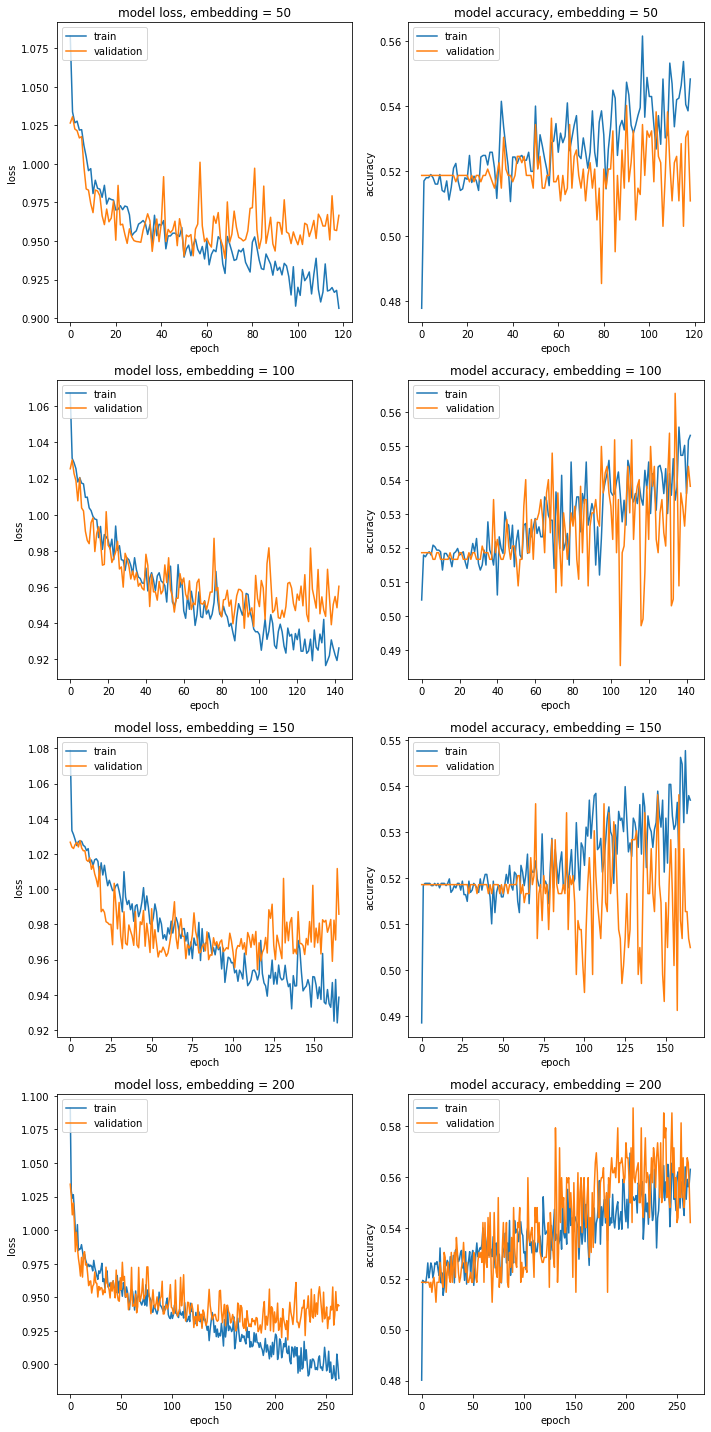

In [ ]:
fig, axes = plt.subplots(num_model, 2, figsize=(10, 20))
for i in range(num_model):
  hist = hist_list[i]
  hist_df = pd.DataFrame(hist.history)
  
  ax1 = axes[i][0]
  ax2 = axes[i][1]

  ax1.plot(hist_df['loss'], label='training')
  ax1.plot(hist_df['val_loss'], label='validation')
  ax1.set_title('model loss, embedding = '+str(embed_size_list[i]))
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.legend(['train', 'validation'], loc='upper left')
  
  ax2.plot(hist_df['accuracy'], label='training')
  ax2.plot(hist_df['val_accuracy'], label='validation')
  ax2.set_title('model accuracy, embedding = '+str(embed_size_list[i]))
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.legend(['train', 'validation'], loc='upper left')
fig.tight_layout()